In [8]:
# standard imports
import numpy as np
import math
import os
import csv
from tqdm import tqdm
import meshio
import matplotlib.pyplot as plt

In [9]:
# custom class imports
from node import node
from cell import cell
from mesh import exp_mesh
from derivatives import finite_differences,polynomial_derivatives
from derivatives import bilinear_derivatives
from isentropic_navier_stokes import Q,L,inner_product

# utility functions
from utilities_modified import *

# Setting Custom Problem

In [10]:
# read su2 mesh file
meshio_mesh = meshio.read("./lam_cyl_comp_air/mesh_cylinder_quad.su2",file_format="su2")
# convert mesh into custom class exp_mesh
mesh = exp_mesh(meshio_mesh,[0.5,0])

    Surface tag  cylinder will be replaced by 1
    Surface tag  farfield will be replaced by 2
-----------------------Custom mesh initialization started-----------------------
------------Shifted and Cylinder coordinates calculated and stored!-------------
-------------------Cell volumes computed in cell structures!--------------------
-------------------Cell centers computed in cell structures!--------------------
----------------------------Node neighbors assigned!----------------------------
----------------------Nodal volume participation computed!----------------------
---------------------Custom mesh initialized successfully!----------------------


# Loading Filedata

In [11]:
# reading file data
data_dir="./lam_cyl_comp_air/mach 0.01/"
data_dict = read_csv_data(data_dir,delay=5000,subsampling=2,max_size=200)

100%|██████████| 200/200 [01:00<00:00,  3.31it/s]


In [12]:
x = data_dict["x"][:,0] - 0.5
y = data_dict["y"][:,0]
u = np.divide(data_dict['Momentum_x'],data_dict['Density'])
v = np.divide(data_dict['Momentum_y'],data_dict['Density'])
a = data_dict['Mach']

In [13]:
q = np.vstack([u,v,a])
q_avg = np.mean(q,1)
q_fluc = q

# Geometric Constants

In [14]:
# DEFINING CONSTANTS
n = mesh.n      # number of nodes
N = mesh.N      # number of cells
T = q.shape[1]  # number of snapshots
alpha = 1       # inner product coefficient
method="fd"     # method for derivative computation
gamma = 1.4     # isentropic coefficient -> material property

In [15]:
# Coordinates of Mesh Nodes
x = data_dict["x"][:,0] - 0.5
y = data_dict["y"][:,0]

# Coordinates of Mesh Cell Centers
x_cell = np.empty(N)
y_cell = np.empty(N)

for cel in mesh.cells:
    i = cel.index
    [x_cell[i],y_cell[i]] = cel.center

# POD Decomposition

In [16]:
# computing correlation matrix with isenctropic inner product
C = np.empty((T,T))
for i in tqdm(range(T)):
    for j in range(i,T):
        C[i,j] = (1/T) * inner_product(mesh,q_fluc[:,i],q_fluc[:,j],alpha)
        C[j,i] = C[i,j]

100%|██████████| 200/200 [10:32<00:00,  3.16s/it]


In [17]:
S,V =  np.linalg.eig(C)
V = np.real(V)

epsilon = 0.97 # [0,1]
acc = 0
num = 0
while acc < epsilon:
    num+=1
    acc = sum(S[:num])/sum(S)    
print("Number of eigenvectors necessary for thresholded reconstruction: \t" + str(num))
if num % 2 == 1:
    num+=1

num = 6

Number of eigenvectors necessary for thresholded reconstruction: 	1


In [18]:
# construct spatial POD Modes - not normalized
pod_modes = np.zeros((3*n,T))
for i in range(len(S)):
    pod_modes += np.outer(q_fluc[:,i],V[i,:])

# normalizing POD Modes
for i in range(len(S)):
    pod_modes[:,i]/=np.sqrt(inner_product(mesh,pod_modes[:,i],pod_modes[:,i],alpha))

In [19]:
# incorrect because POD modes are not orthonormal in euclidean space but in problem space
coeffs = np.matmul(np.linalg.pinv(pod_modes),q_fluc)

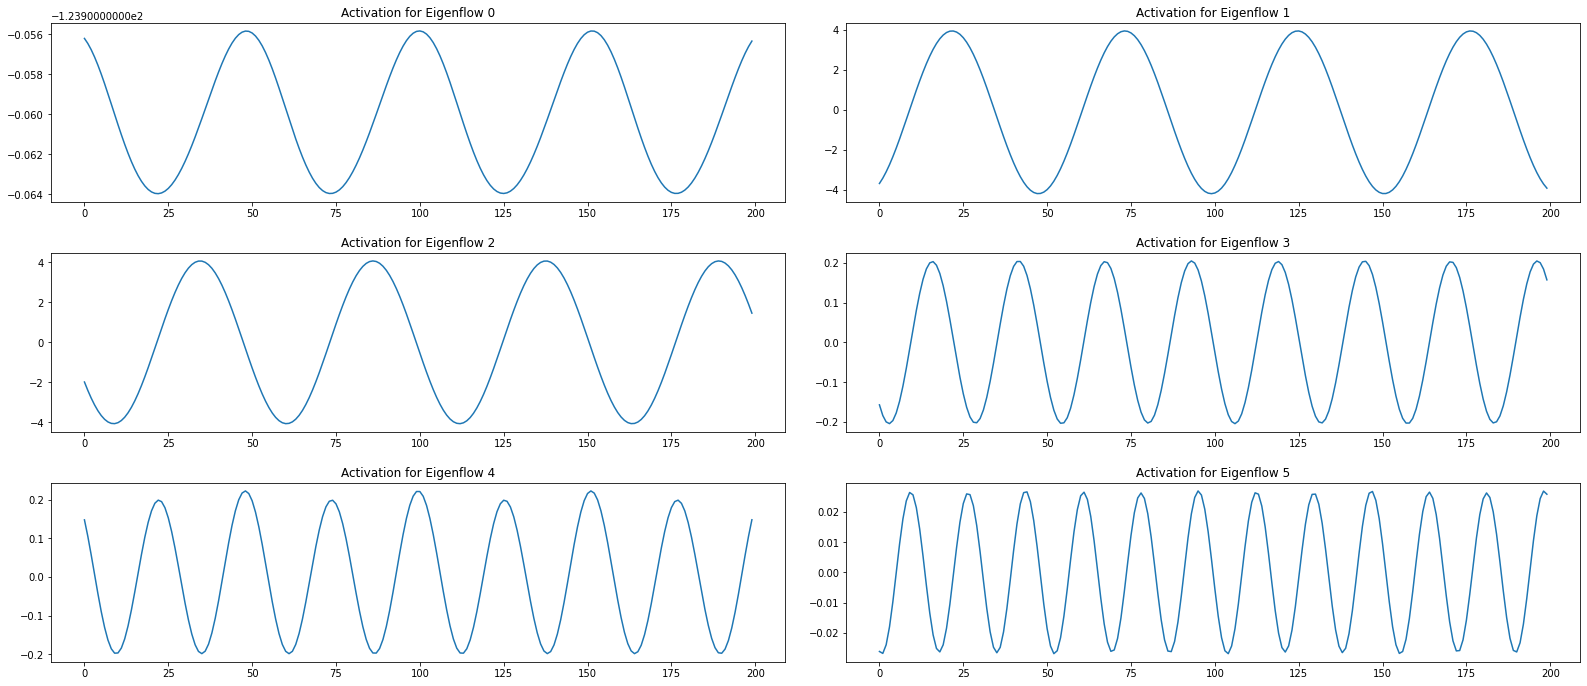

In [20]:
plot_activations(coeffs,num)

## Galerkin System

In [27]:
method = "pd"
output = "node"
dim = n

# initialie arrays for parameters
L_ = np.empty((num,num))
Q_ = [np.empty((num,num,)) for x in range(num)]

# pod basis for computation
if output=="cell":
    modes = np.empty((3*dim,num))
    for i in range(num):
        modes[:N,i] = mesh.compute_cell_values_from_node_data(pod_modes[:n,i])
        modes[N:2*N,i] = mesh.compute_cell_values_from_node_data(pod_modes[n:2*n,i])
        modes[2*N:3*N,i] = mesh.compute_cell_values_from_node_data(pod_modes[2*n:3*n,i])
else:
    modes = pod_modes


# compute L and Q operators for projection
Q_tmp = np.empty((num,num,3*dim))
L_tmp = np.empty((num,3*dim))

for i in tqdm(range(num)):
    L_tmp[i,:] = L(mesh,pod_modes[:,i],method=method,output=output)
    for j in range(num):
        Q_tmp[i,j] = Q(mesh,pod_modes[:,i],pod_modes[:,j],method=method,output=output)

# compute ODE coefficients
for k in tqdm(range(num)):
    for i in range(num):
        L_[k,i] = inner_product(mesh,L_tmp[i,:],pod_modes[:,k],alpha)
        for j in range(num):
            Q_[k][i,j] = inner_product(mesh,Q_tmp[i,j],pod_modes[:,k],alpha)

100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


# Solving ODE system

In [32]:
# initial conditions for the activations are obtained as activations on the initial timeframe of the data matrix
a0 = coeffs[:num,0] #initial conditions
dt = 0.001
t0 = 0
tmax = 4
sampling_span = np.linspace(t0,tmax-dt,num=int(tmax/dt))
# static viscosity
nu =  1/100 #1.516e-5

# defining ode function for node based coefficients
def galerkin_system(t,a):
    # set global variables references
    global Q_, L_, nu
    
    a = np.expand_dims(a,1)
    a_dot = np.empty_like(a)
    
    quad = np.zeros((num,1))

    for k in range(a_dot.shape[0]):
        quad[k] = np.matmul(np.matmul(a.T,np.array(Q_)[:,:,k]),a)  
    a_dot = np.matmul((nu*L_),a) + quad
    return a_dot

In [33]:
from scipy.integrate import solve_ivp
sol = solve_ivp(galerkin_system,(t0,tmax),a0,method='LSODA',t_eval=sampling_span)
sol

TypeError: unsupported operand type(s) for *: 'float' and 'function'

In [ ]:
def reconstruct_flow(activations,U,avg,num,rang=(0,100)):
    low,high = rang
    flow = np.repeat(np.expand_dims(avg,1),high-low,1)
    for i in range(num):
         flow += np.outer(U[:,i],activations[i,low:high])
    return flow

In [ ]:
# Galerkin model based on discrete reconstruction as q = \bar{q}+\sum_i^n a_i(t)*\phi_i(x)
d = int(num/2)
fig,ax = plt.subplots(d,2,figsize=(15,10))
fig.tight_layout(pad=3.0)

t = sampling_span

# add plots over full time domain
for i in range(num):
    if num <= 2:
        ax[int(i%2)].plot(t,sol.y[i,:len(t)])
        ax[int(i%2)].title.set_text("Activation for Eigenflow " + str(i))
    else:
        ax[int(i/2)][int(i%2)].plot(t,sol.y[i,:len(t)])
        ax[int(i/2)][int(i%2)].title.set_text("Activation for Eigenflow " + str(i))

In [ ]:
rec = reconstruct_flow(sol.y,pod_modes,q_avg,num,rang=(0,1000))

In [ ]:
sample = 900
# computing total velocity!
data = np.sqrt(np.multiply(rec[:n,sample],rec[:n,sample])+np.multiply(rec[n:2*n,sample],rec[n:2*n,sample]))
# visualizing
fig,ax = plt.subplots(1,1,figsize=(10,6))
plot_cylinder(x,y,data,cmap=get_cmap(False),ax=ax,clip=False,shifted=True)